In [2]:
%pylab inline --no-import-all
import cv2
import os

Populating the interactive namespace from numpy and matplotlib


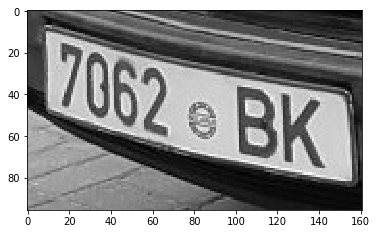

In [809]:
plates_dir = "data/borders/"
plate_file = os.path.join(plates_dir, os.listdir(plates_dir)[4])
img = cv2.imread(plate_file, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')

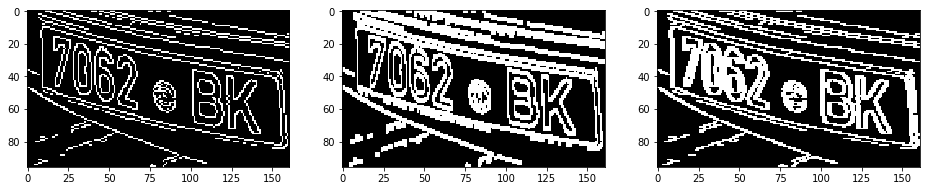

In [810]:
edges = cv2.Canny(img, 150, 220)
edgesHor = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3)))
edgesVer = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1)))

fig, ax =plt.subplots(1, 3, figsize=(16, 8)) 

ax[0].imshow(edges, cmap='gray')
ax[1].imshow(edgesHor, cmap='gray')
ax[2].imshow(edgesVer, cmap='gray')

[(0, 3), (160, 31)]
[(0, 50), (160, 84)]
[(0, 10), (160, 38)]
[(0, 6), (160, 40)]
[(0, 4), (160, 44)]
[(4, 0), (160, 32)]
[(14, 0), (160, 20)]
[(0, 47), (160, 87)]
[(0, 9), (160, 43)]
[(0, 13), (160, 41)]
[(0, 2), (160, 18)]
[(0, 4), (160, 20)]
[(0, 53), (160, 82)]
[(0, 15), (160, 37)]
[(0, 7), (160, 29)]
[(0, 20), (160, 36)]


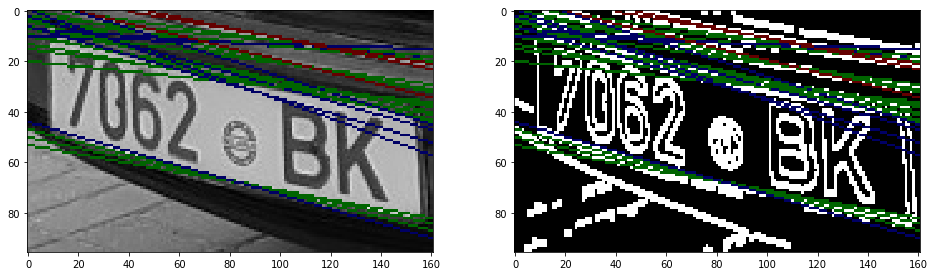

In [811]:
houghHor = cv2.HoughLines(edgesHor, 1, np.pi/90, width//2)
houghHor = houghHor[:len(houghHor)//4]

img_copy = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
edges_copy = cv2.cvtColor(edgesHor, cv2.COLOR_GRAY2RGB)

def bounded(val, low, high):
    
    if val < low:
        return low
    elif val > high:
        return high
    else:
        return val

height, width = edgesHor.shape
h = height - 1
w = width - 1
lines = []

for i, (rho, theta) in enumerate(houghHor[:, 0]):            
    sin = np.sin(theta)
    cos = np.cos(theta)
    tan = np.tan(theta)
    y0 = rho * sin
    x0 = rho * cos
    skew = x0*y1 > 0
    

    x1 = bounded(rho/cos, 0, w)
    y1 = bounded(rho/sin, 0, h)

    x2 = bounded(x0 + (y0-h)*tan, 0, w)
    y2 = bounded(y0 + (x0-w)/tan, 0, h)
    if skew and y2 < y1:
        x1, x2 = x2, x1
    if not skew and y2 > y2:
        x1, x2 = x2, x1
        
    length = np.sqrt((y1-y2)**2 + (x1-x2)**2)
    line = [(int(x1), int(y1)), (int(x2), int(y2))]
    
    if i == 0:
        etalon_len = length
        etalon_angle = theta
            
    if 2 * np.abs(etalon_angle - theta) / np.abs(etalon_angle + theta) > 0.05:
        color = (0, 0, 100)
    elif 2 * np.abs(length - etalon_len) / (length + etalon_len) > 0.1:
        color = (100, 0, 0)
    else:
        color = (0, 100, 0)
        print(line)
        lines.append(line)

    cv2.line(img_copy, *line, color, 1)
    cv2.line(edges_copy, *line, color, 1)

lines = np.array(lines)
Fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(img_copy)
ax2.imshow(edges_copy)

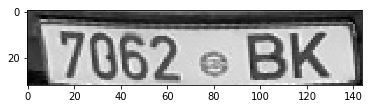

In [812]:
topline = min(lines, key=lambda l: min(l[0][1], l[1][1]))
bottomline = max(lines, key=lambda l: max(l[0][1], l[1][1]))

rect_from = np.array([
    topline[0], topline[1], bottomline[1], bottomline[0]
], dtype=np.float32)
rect_to = np.array([
    [0, 0], [144, 0], [144, 32], [0, 32]
], dtype=np.float32)

transform = cv2.getPerspectiveTransform(rect_from, rect_to)

plt.imshow(cv2.warpPerspective(img, transform, (144, 32)), cmap='gray')